In [1]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



In [2]:
input_shape = (128, 128, 3)
data_dir = 'dataset'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]

X = []
Y = []
#binary classification
#Labels are assigned as 1 for real images and 0 for fake images.
for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y

#Normalization
X = np.array(X)
#The labels are then one-hot encoded using to_categorical from Keras. This is suitable for binary classification with two classes.
Y = to_categorical(Y, 2)

#Reshape
X = X.reshape(-1, 128, 128, 3)


# Train-Test split
# Splitting into training, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.3, random_state=5)

# Now X_test and Y_test contain your test data and corresponding labels


In [3]:
'''This code sets up a model architecture where the InceptionResNetV2 is used as a feature extractor, followed by a Global Average Pooling layer to reduce spatial dimensions, and finally, a Dense layer with two units and softmax activation for binary classification. The model is compiled using the Adam optimizer with specified parameters, binary crossentropy loss, and accuracy as the evaluation metric.'''

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import optimizers

#binary classification model using the InceptionResNetV2 architecture as a feature extractor

googleNet_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
googleNet_model.trainable = True


model = Sequential()
model.add(googleNet_model)
#Global Average Pooling layer to reduce the spatial dimensions of the feature maps.
model.add(GlobalAveragePooling2D())
#A Dense layer with two units and softmax activation is added for binary classification.
model.add(Dense(units=2, activation='softmax'))

# Use legacy Adam optimizer
optimizer =  tf.keras.optimizers.legacy.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 2, 2, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 3074      
                                                                 
Total params: 54339810 (207.29 MB)
Trainable params: 54279266 (207.06 MB)
Non-trainable params: 60544 (236.50 KB)
_________________________________________________________________


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [4]:
print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_val:", Y_val.shape)


Shape of X_train: (2621, 128, 128, 3)
Shape of Y_train: (2621, 2)
Shape of X_val: (786, 128, 128, 3)
Shape of Y_val: (786, 2)


In [5]:
print("NaN values in X_train:", np.isnan(X_train).any())
print("Inf values in X_train:", np.isinf(X_train).any())

NaN values in X_train: False


Inf values in X_train: False


Epoch 1/10


27/27 [==============================] - 171s 5s/step - loss: 0.6555 - accuracy: 0.6650 - val_loss: 0.6621 - val_accuracy: 0.6705
Epoch 2/10
27/27 [==============================] - 131s 5s/step - loss: 0.5598 - accuracy: 0.8035 - val_loss: 0.6821 - val_accuracy: 0.6209
Epoch 3/10
27/27 [==============================] - 131s 5s/step - loss: 0.4849 - accuracy: 0.8562 - val_loss: 0.6736 - val_accuracy: 0.5865
Epoch 4/10
27/27 [==============================] - 131s 5s/step - loss: 0.4151 - accuracy: 0.8943 - val_loss: 0.6502 - val_accuracy: 0.6031
Epoch 5/10
27/27 [==============================] - 131s 5s/step - loss: 0.3541 - accuracy: 0.9100 - val_loss: 0.6178 - val_accuracy: 0.6552
Epoch 6/10
27/27 [==============================] - 129s 5s/step - loss: 0.2946 - accuracy: 0.9409 - val_loss: 0.5752 - val_accuracy: 0.7163
Epoch 7/10
27/27 [==============================] - 119s 4s/step - loss: 0.2402 - accuracy: 0.9481 - val_loss: 0.5407 - val_accuracy: 0.7506
Epoch 8/10


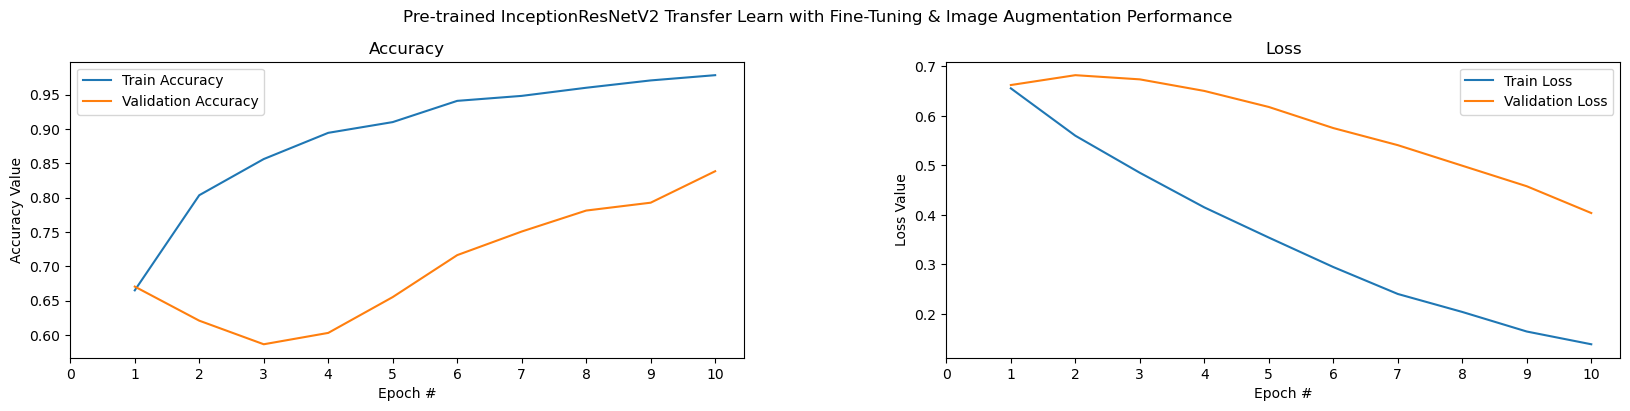

In [6]:
EPOCHS=10
history = model.fit(X_train, Y_train, epochs=EPOCHS,batch_size=100,
                    validation_data=(X_val, Y_val))

# Plot the training history
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained InceptionResNetV2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

# Ensure epoch_list has the correct length
epoch_list = list(range(1, len(history.history['accuracy']) + 1))

ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS + 1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS + 1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Epoch 1/10
23/23 [==============================] - 106s 5s/step - loss: 0.1214 - accuracy: 0.9798 - val_loss: 0.2184 - val_accuracy: 0.9365
Epoch 2/10
23/23 [==============================] - 106s 5s/step - loss: 0.1051 - accuracy: 0.9829 - val_loss: 0.1828 - val_accuracy: 0.9594
Epoch 3/10
23/23 [==============================] - 109s 5s/step - loss: 0.0870 - accuracy: 0.9861 - val_loss: 0.1526 - val_accuracy: 0.9670
Epoch 4/10
23/23 [==============================] - 108s 5s/step - loss: 0.0763 - accuracy: 0.9888 - val_loss: 0.1260 - val_accuracy: 0.9772
Epoch 5/10
23/23 [==============================] - 108s 5s/step - loss: 0.0706 - accuracy: 0.9879 - val_loss: 0.1004 - val_accuracy: 0.9797
Epoch 6/10
23/23 [==============================] - 106s 5s/step - loss: 0.0625 - accuracy: 0.9910 - val_loss: 0.0874 - val_accuracy: 0.9822
Epoch 7/10
23/23 [==============================] - 112s 5s/step - loss: 0.0568 - accuracy: 0.9906 - val_loss: 0.0761 - val_accuracy: 0.9822
Epoch 8/10
23

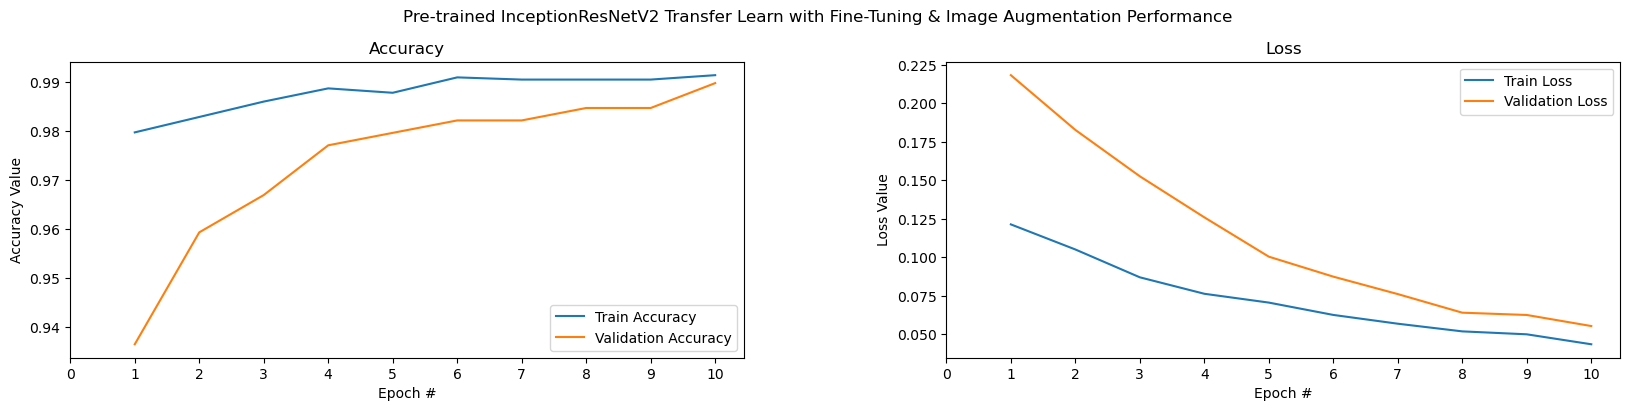

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta=0, 
                               patience=3, 
                               verbose=1, 
                               mode='min')

EPOCHS = 10
BATCH_SIZE = 100

history = model.fit(X_train, Y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=0.15,  # Use a validation split instead of separate validation data
                    callbacks=[early_stopping], 
                    verbose=1)

# Plot the training history
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained InceptionResNetV2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

# Ensure epoch_list has the correct length
epoch_list = list(range(1, len(history.history['accuracy']) + 1))

ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS + 1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS + 1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


118/118 [==============================] - 62s 467ms/step
True positive =  2916
False positive =  70
False negative =  72
True negative =  687




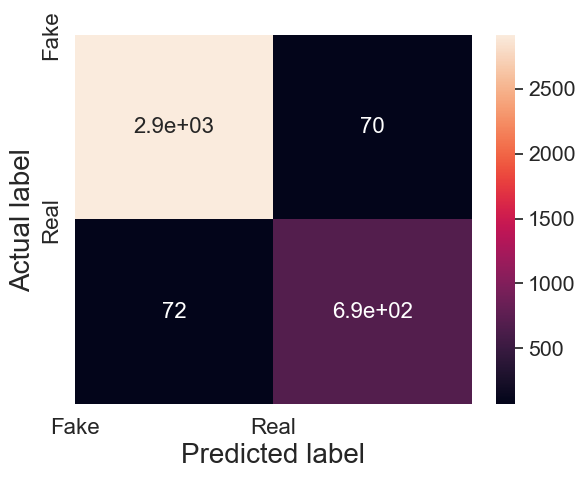

In [8]:
# Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4)  # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})  # font size
    plt.ylabel('Actual label', size=20)
    plt.xlabel('Predicted label', size=20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size=16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size=16)
    plt.ylim([2, 0])
    plt.show()

print_confusion_matrix(Y_val_org, model.predict(X))


In [9]:
model.save("deepfake-detection-model.keras")
